In [ ]:
start_time <- Sys.time()

install.packages(c("tidyverse", "BiocManager", "gridExtra", "ggrepel", "devtools"))
BiocManager::install(c("airway","AnnotationHub", "clusterProfiler", "enrichplot", "biomaRt", "org.Hs.eg.db", "DESeq2"))
#devtools::install_url("http://cran.r-project.org/src/contrib/Archive/dbplyr/dbplyr_1.3.0.tar.gz")
install.packages('dbplyr')
end_time <- Sys.time()
end_time - start_time

also installing the dependency ‘dbplyr’


Warning message in install.packages(c("tidyverse", "BiocManager", "gridExtra", "ggrepel", :
“installation of package ‘dbplyr’ had non-zero exit status”
Warning message in install.packages(c("tidyverse", "BiocManager", "gridExtra", "ggrepel", :
“installation of package ‘tidyverse’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.12), R 4.0.0 (2020-04-24)

Installing package(s) 'airway', 'AnnotationHub', 'clusterProfiler',
  'enrichplot', 'biomaRt', 'org.Hs.eg.db', 'DESeq2'

Warning message in install.packages(...):
“installation of package ‘AnnotationHub’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘biomaRt’ had non-zero exit status”


In [1]:
library("tidyverse")
library("ggplot2")
library("BiocManager")
library("gridExtra")
library("ggrepel")
library("airway")
library("AnnotationHub")
library("clusterProfiler")
library("enrichplot")
library("biomaRt")
library("org.Hs.eg.db")


── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Bioconductor version '3.11' is out-of-date; the current release version '3.12'
  is available with R version '4.0'; see https://bioconductor.org/install


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package:

Import the Airway data rlog transformed counts:


In [15]:
rld <- readRDS("rld.rds")

# Using biomaRt

The [biomaRt](https://bioconductor.org/packages/release/bioc/html/biomaRt.html) package makes it easy to query public repositories of biological data. We can use biomaRt to query Ensembl for annotations so that we can look for 'housekeeping genes' which are typically considered to be stably expressed and shouldn't show large variations across different samples. We have selected a list of genes based on two publications that queried public cancer genome data to find housekeeping genes for use with RNA-seq from cancer cell lines (https://doi.org/10.1186/s12859-019-2809-2, https://doi.org/10.3389/fgene.2019.00097). 

There are many other ways to retrieve annotation information, such as [AnnotationHub](https://bioconductor.org/packages/release/bioc/html/AnnotationHub.html) or [AnnotationDbi](https://bioconductor.org/packages/release/bioc/html/AnnotationDbi.html). The [GenomeInfoDb](https://bioconductor.org/packages/release/bioc/html/GenomeInfoDb.html)  package is also helpful for converting between naming conventions between different annotation resources.

First, let's load biomaRt and make a vector of the gene symbols from the published data:

In [16]:

housekeeping <- c('PCBP1','RER1', 'RPN1', 'PUM1', 'IPO8')

Then we can see what BioMarts are available:

Let's use `ENSEMBL_MART_ENSEMBL` (you might get an error that says `Ensembl site unresponsive, trying uswest mirror`, run `?useEnsembl` to get more information about available options).


In [17]:
ensembl <- useEnsembl(biomart = 'ENSEMBL_MART_ENSEMBL', mirror = 'uswest')

Then we can see which datasets are available for `hsapiens`

In [18]:
searchDatasets(mart = ensembl, pattern = 'hsapiens')

,dataset,description,version
,<I<chr>>,<I<chr>>,<I<chr>>
80,hsapiens_gene_ensembl,Human genes (GRCh38.p13),GRCh38.p13


Now we can put it all together to create a BioMart object: (you might get an error that says `Ensembl site unresponsive, trying uswest mirror`)

In [19]:
ensembl <- useEnsembl(biomart = 'ENSEMBL_MART_ENSEMBL', dataset='hsapiens_gene_ensembl', mirror = 'uswest')

We can use the `listAttributes` function to see what information is available in `ensembl`

In [20]:
head(listAttributes(ensembl))

,name,description,page
,<chr>,<chr>,<chr>
1,ensembl_gene_id,Gene stable ID,feature_page
2,ensembl_gene_id_version,Gene stable ID version,feature_page
3,ensembl_transcript_id,Transcript stable ID,feature_page
4,ensembl_transcript_id_version,Transcript stable ID version,feature_page
5,ensembl_peptide_id,Protein stable ID,feature_page
6,ensembl_peptide_id_version,Protein stable ID version,feature_page


We can use `getBM` to query the BioMart object:

In [21]:
ensembl_bm <- getBM(attributes = c('ensembl_gene_id','hgnc_symbol'),
      filters = 'hgnc_symbol',
      values = housekeeping, 
      mart = ensembl)
ensembl_bm

ensembl_gene_id,hgnc_symbol
<chr>,<chr>
ENSG00000133704,IPO8
ENSG00000169564,PCBP1
ENSG00000134644,PUM1
ENSG00000157916,RER1
ENSG00000163902,RPN1


Let's look at the `rlog` normalized counts for our housekeeping genes:

In [22]:
housekeeping_rld <- data.frame(assay(rld)[ensembl_bm$ensembl_gene_id, ])
head(housekeeping_rld)

Loading required package: DESeq2



,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000133704,10.41685,10.23479,10.45273,10.39731,10.53719,10.48919,10.46832,10.45651
ENSG00000169564,10.48063,10.56330,10.22373,10.31371,10.16660,10.37503,10.39615,10.36473
ENSG00000134644,11.20999,11.22307,10.98335,11.12745,11.21067,11.24240,11.09791,11.22956
ENSG00000157916,10.98437,11.19663,11.00188,11.20675,10.98911,11.22096,10.93644,11.10573
ENSG00000163902,11.68383,11.83756,11.71771,11.89697,11.71163,12.04157,11.57565,11.70463


The `ensembl_gene_id` is currently stored as the rownames. Let's go ahead and turn it into a column in the data frame:

In [23]:
housekeeping_rld$ensembl_gene_id <- rownames(housekeeping_rld)
head(housekeeping_rld)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521,ensembl_gene_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000133704,10.41685,10.23479,10.45273,10.39731,10.53719,10.48919,10.46832,10.45651,ENSG00000133704
ENSG00000169564,10.48063,10.56330,10.22373,10.31371,10.16660,10.37503,10.39615,10.36473,ENSG00000169564
ENSG00000134644,11.20999,11.22307,10.98335,11.12745,11.21067,11.24240,11.09791,11.22956,ENSG00000134644
ENSG00000157916,10.98437,11.19663,11.00188,11.20675,10.98911,11.22096,10.93644,11.10573,ENSG00000157916
ENSG00000163902,11.68383,11.83756,11.71771,11.89697,11.71163,12.04157,11.57565,11.70463,ENSG00000163902


Then we use the `gather` function to convert the data to a long format.

In [24]:
housekeeping_rld_tidy <- gather(housekeeping_rld, key = 'sample', value = 'rlog_counts', SRR1039508:SRR1039521)
head(housekeeping_rld_tidy)

,ensembl_gene_id,sample,rlog_counts
,<chr>,<chr>,<dbl>
1,ENSG00000133704,SRR1039508,10.41685
2,ENSG00000169564,SRR1039508,10.48063
3,ENSG00000134644,SRR1039508,11.20999
4,ENSG00000157916,SRR1039508,10.98437
5,ENSG00000163902,SRR1039508,11.68383
6,ENSG00000133704,SRR1039509,10.23479


Let's add the annotation information we pulled from biomaRt:

In [25]:
#housekeeping_rld_tidy <- inner_join(ensembl_bm, housekeeping_rld_tidy)
housekeeping_rld_tidy<- merge(ensembl_bm, housekeeping_rld_tidy, by = 'ensembl_gene_id')
head(housekeeping_rld_tidy)

,ensembl_gene_id,hgnc_symbol,sample,rlog_counts
,<chr>,<chr>,<chr>,<dbl>
1,ENSG00000133704,IPO8,SRR1039508,10.41685
2,ENSG00000133704,IPO8,SRR1039509,10.23479
3,ENSG00000133704,IPO8,SRR1039513,10.39731
4,ENSG00000133704,IPO8,SRR1039516,10.53719
5,ENSG00000133704,IPO8,SRR1039520,10.46832
6,ENSG00000133704,IPO8,SRR1039521,10.45651


Let's look at the expression of our housekeeping genes to make sure they look stably expressed in our data:

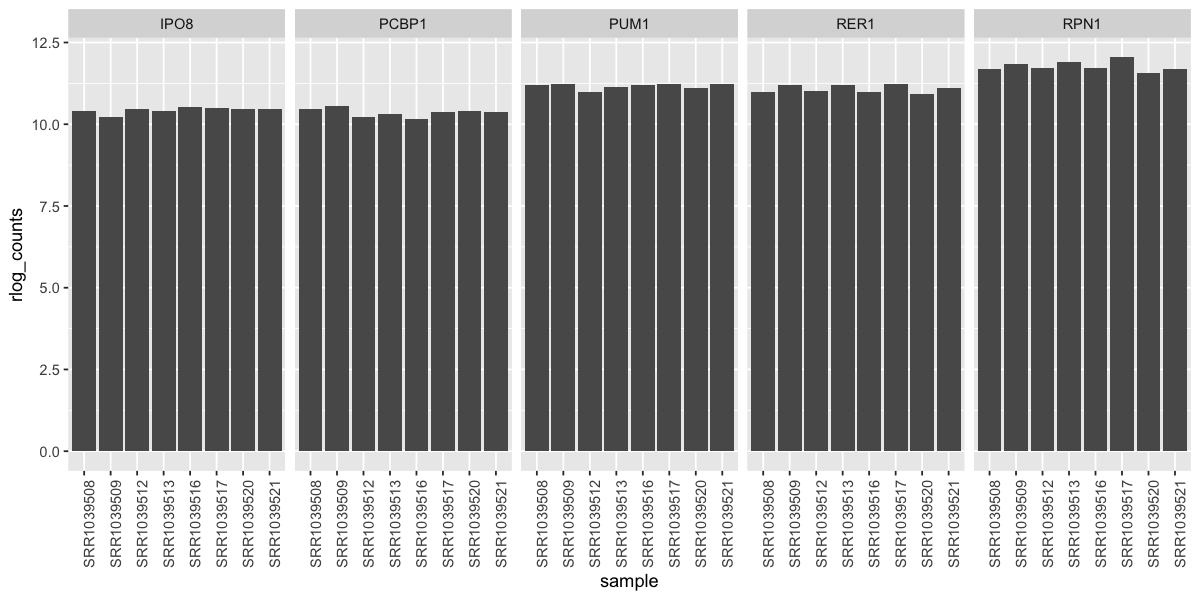

In [26]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(housekeeping_rld_tidy, aes(x=sample, y=rlog_counts)) + 
geom_bar(stat="identity") +
facet_wrap(~hgnc_symbol, nrow = 1) +
theme(axis.text.x = element_text(angle = 90))

These housekeeping genes look stably expressed across each sample.

# Ontology Analysis

Now that we have information about which genes are differentially expressed, we can see if there is any enrichment in any functional gene groups. Two commonly used methods to look for enrichment are overrepresentation analysis (ORA) or gene set enrichment analysis (GSEA). **Over Representation Analysis (ORA)** looks for functions or processes that are over-represented (= enriched) in an experimentally-derived gene list. The background used by default is all of the genes that have an annotation. This will find genes where the difference is large, but will not detect a situation where the difference is small but coordinated across a set of genes. **Gene Set Enrichment (GSEA)** aggregates per-gene statistics across genes in a set. It takes a ranked list of genes and determines whether members of a gene set are randomly distributed throughout that list or if they are found primarily at the top or bottom of the list. GSEA will calculate an enrichment score based on whether a gene set is over-represented at the top or bottom fo the list, estimate the significance of the enrichment, and adjust for multiple hypothesis testing. 

There are many packages for running these types of analyses ([gage](https://www.bioconductor.org/packages/release/bioc/html/gage.html), [EnrichmentBrowser](https://www.bioconductor.org/packages/release/bioc/html/EnrichmentBrowser.html)) and many of them will use similar approaches to test for enrichment. We will use [clusterProfiler](https://www.bioconductor.org/packages/release/bioc/html/clusterProfiler.html).

We will use [gene ontologies](http://geneontology.org/docs/ontology-documentation/) to organize the genes into groups based on their role in an organism. Gene Ontology loosely organize genes into three hierarchical graphs that correspond to three large umbrella categories -- **Molecular Function, Cellular Component, and Biological Process**. You can read the formal descriptions of these categories in the documentation linked above. A quote from the documentation illustrates an example of how these categories are related:

```
In an example of GO annotation, the gene product “cytochrome c” can be described by the molecular function oxidoreductase activity, the biological process oxidative phosphorylation, and the cellular component mitochondrial matrix.
```

First, let's get the annotations -- this time we'll use [AnnotationHub](https://www.bioconductor.org/packages/release/bioc/html/AnnotationHub.html). Load the packages and query AnnotationHub for a Homo sapiens OrgDb:


snapshotDate(): 2020-04-27



AnnotationHub with 1 record
# snapshotDate(): 2020-04-27
# names(): AH79577
# $dataprovider: ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/
# $species: Homo sapiens
# $rdataclass: OrgDb
# $rdatadateadded: 2020-05-01
# $title: org.Hs.eg.db.sqlite
# $description: NCBI gene ID based annotations about Homo sapiens
# $taxonomyid: 9606
# $genome: NCBI genomes
# $sourcetype: NCBI/ensembl
# $sourceurl: ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/, ftp://ftp.ensembl.org/p...
# $sourcesize: NA
# $tags: c("NCBI", "Gene", "Annotation") 
# retrieve record with 'object[["AH79577"]]' 

loading from cache

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.06% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



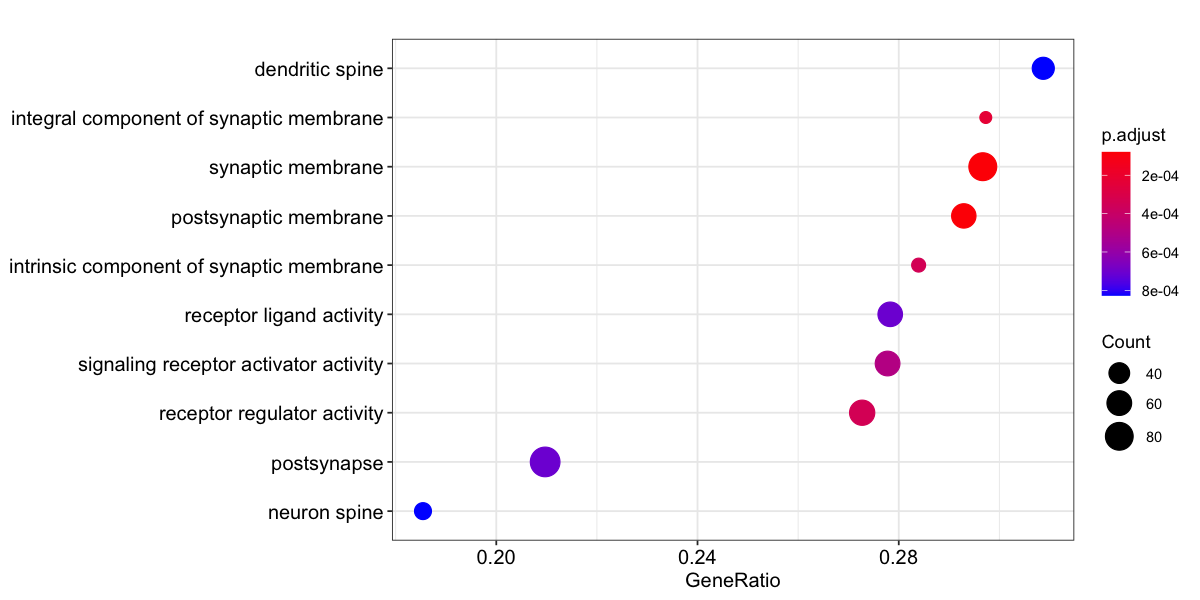

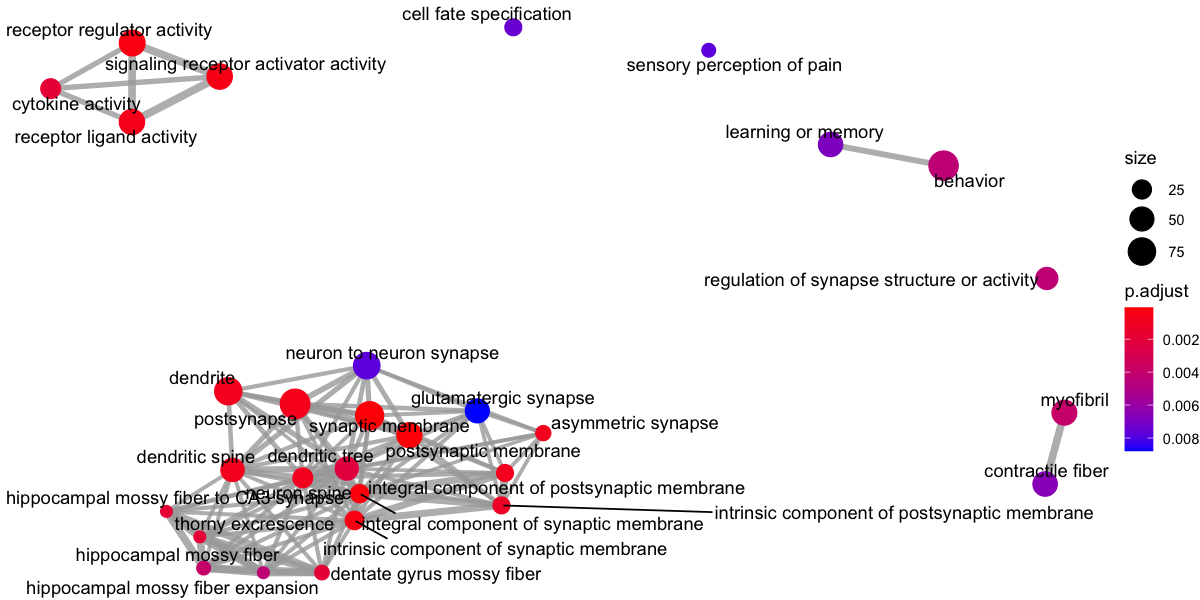

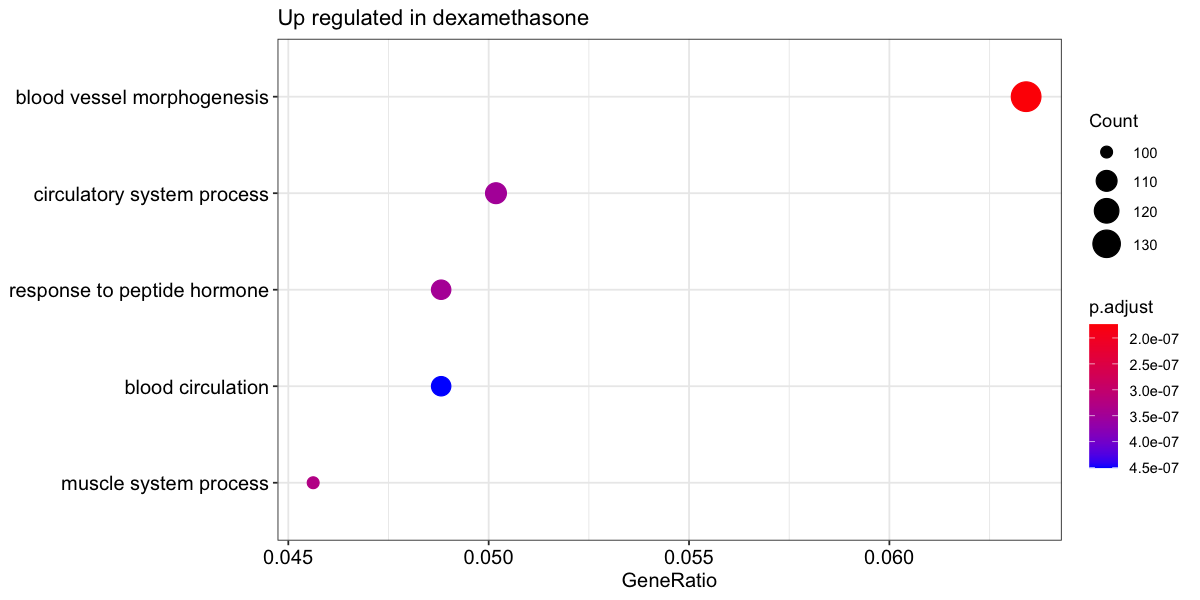

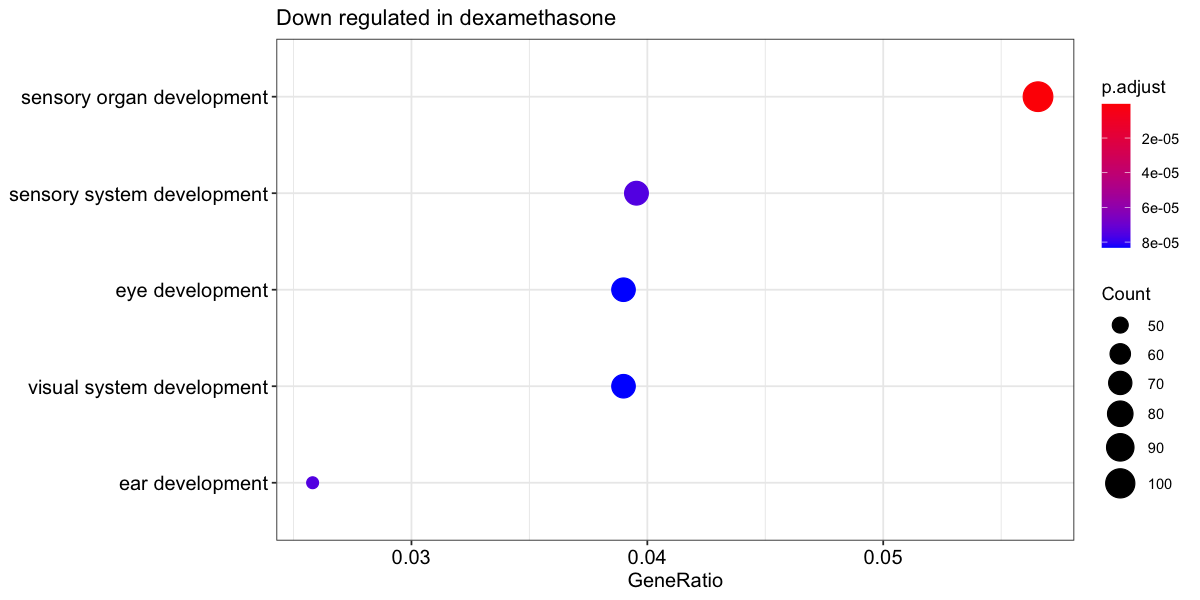

In [36]:
library('AnnotationHub')
library('clusterProfiler')
library('DESeq2')
library('airway')
library('biomaRt')
library('dplyr')
library('tidyr')
library('enrichplot')
res <- readRDS("res.rds")
ah <- AnnotationHub()
AnnotationHub::query(ah, pattern = c("Homo sapiens", "OrgDb"))
orgdb <- AnnotationHub::query(ah, pattern = c("Homo sapiens", "OrgDb"))[["AH79577"]]
res <- tidyr::drop_na(data.frame(res))
gene_list <- res$log2FoldChange
names(gene_list) <- c(rownames(res))
gene_list <- sort(gene_list, decreasing = TRUE)
set.seed(42)
gsea_out <- gseGO(
    geneList = gene_list,
    OrgDb = orgdb,
    ont = 'ALL',
    keyType = 'ENSEMBL',
    seed = TRUE)
library(enrichplot)
dotplot(gsea_out)

options(repr.plot.height=5, repr.plot.width=10)
emapplot(gsea_out)
up_genes <- data.frame(res) %>% dplyr::filter(padj < 0.1 & log2FoldChange > 0)
down_genes <- data.frame(res) %>% dplyr::filter(padj < 0.1 & log2FoldChange < 0)
up_ego <- enrichGO(gene = rownames(up_genes),
          keyType = 'ENSEMBL',
          ont = 'BP',
          universe = rownames(res),
          OrgDb = orgdb,
          readable = TRUE)
dotplot(up_ego, showCategory = 5) + ggtitle('Up regulated in dexamethasone')

down_ego <- enrichGO(gene = rownames(down_genes),
          keyType = 'ENSEMBL',
          ont = 'BP',
          universe = rownames(res),
          OrgDb = orgdb,
          readable = TRUE)
dotplot(down_ego, showCategory = 5) + ggtitle('Down regulated in dexamethasone')

Let's assign the OrgDb to an obect so we can use it later, you can use `keytypes(orgdb)` after to see what gene ID types are available.

We will use the functions `gseGO` and `enrichGO` from clusterProfiler.

- `gseGO` is a GSEA method, it takes a order ranked geneList as input and uses a Kolmogorov Smirnov test to run Gene Set Enrichment Analysis (GSEA) [Subramanian et al. 2005](https://www.ncbi.nlm.nih.gov/pmc/articles/pmid/16199517/). GSEA is useful in scenarios where the fold changes are subtle but modules of genes are regulated in a coordinated way. 

- `enrichGO` is an ORA method and takes a list of genes (does not neet to be ranked) and uses Fisher's exact test with a hypergeometric distribution to run Enrichment Analysis [Boyle et al. 2004](https://academic.oup.com/bioinformatics/article/20/18/3710/202612). 

First, lets make a ranked geneList from our DESeq2 results, such that genes with the strongest up regulation are at the top and genes with the strongest down regulation are at the bottom. First we will drop rows with `NA`

Then we can run `gseGO`. We are setting a seed and using the `seed = TRUE` argument because we want gseGO to deal with ties consistently -- otherwise we might get different data every time we run the analysis since gseGO will arbitrarily break ties in the rankings. The ties shouldn't present a huge issue as long as the ties percentage in your data is low.

- By using `keyType = 'ENSEMBL'` we are telling the function that our gene IDs are in `ENSEMBL` format and by setting `ont = 'ALL'` we are indicating we want to look at all three of the ontologies -- `Biological Process`, `Cellular Component`, and `Molecular Function`. Run `?gseGO` for a full account of the function and its arguments      

- There are many options for visualizing the enrichment, you can see more details [here](http://yulab-smu.top/clusterProfiler-book/chapter12.html) -- let's start with a dotplot:

The size of the dot indicates how many members of the group are represented in the enrichment and the adjusted p-value is the Benjamini-Hochberg corrected p-value. `GeneRatio` is `k/n`, where for a given category (e.g. 'receptor regulator activity') `k` is the overlap of 'receptor regulator activity' genes in `gene_list` compared to all 'receptor regulator activity' genes in the org.db, where `n` is the overlap of all genes in `gene_list` compares to all genes in the org.db.

You can also use `emapplot`, which will group genes in overlapping categories:

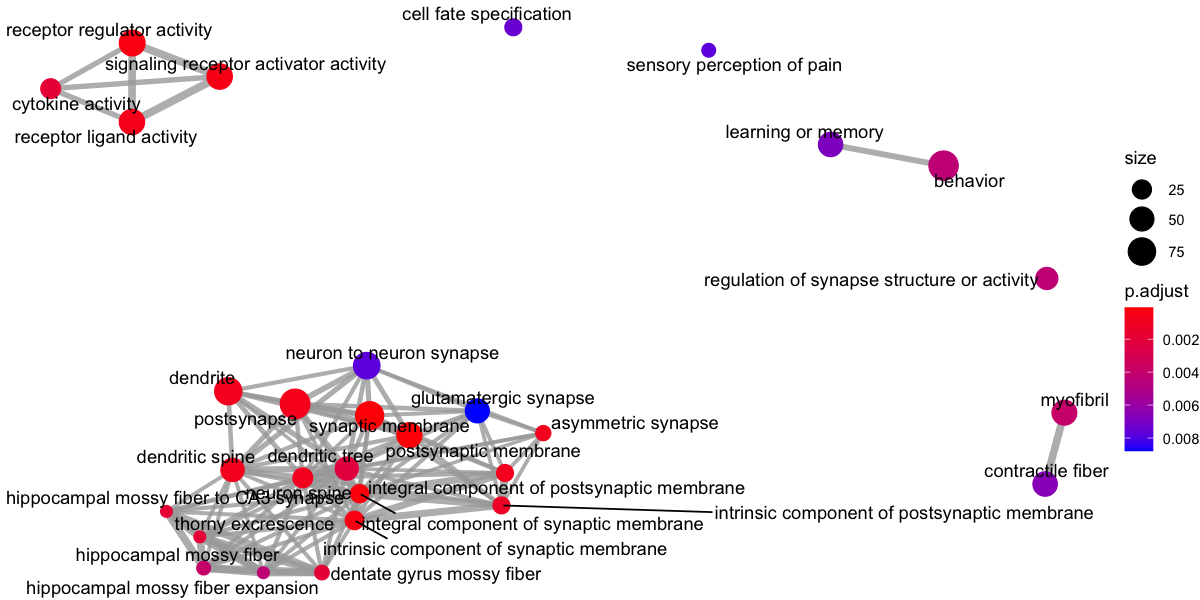

We can also use `enrichGO`, which takes a list of genes that are not ranked. We will separate out the up and down regulated genes from `res` first.

Then we can run `enrichGO` on the up and down regulated genes and make dotplots.

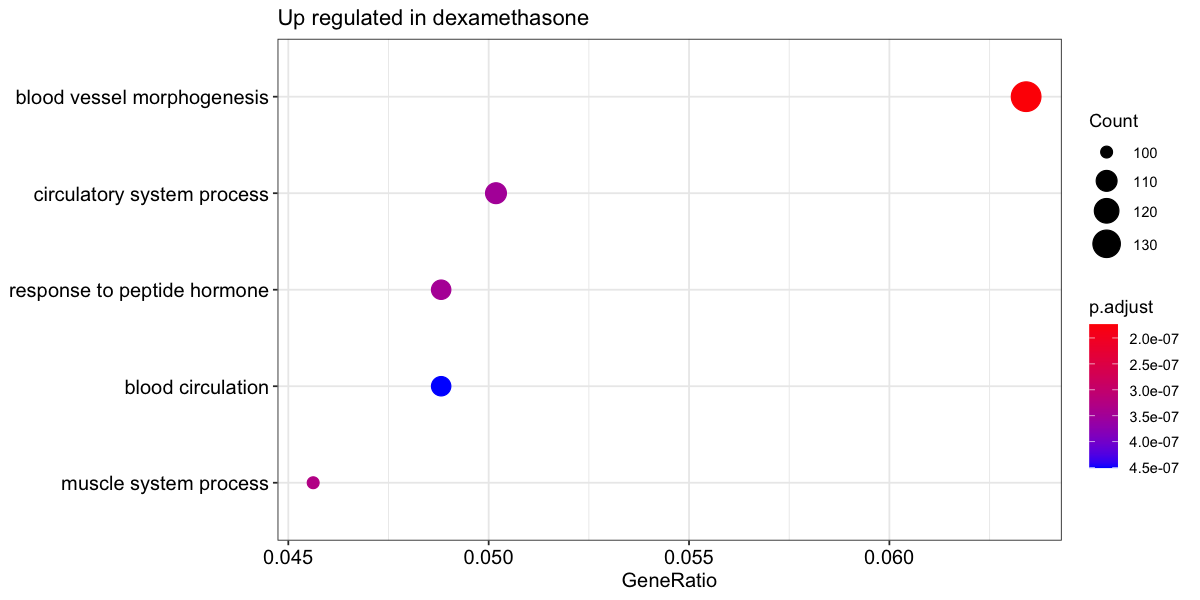

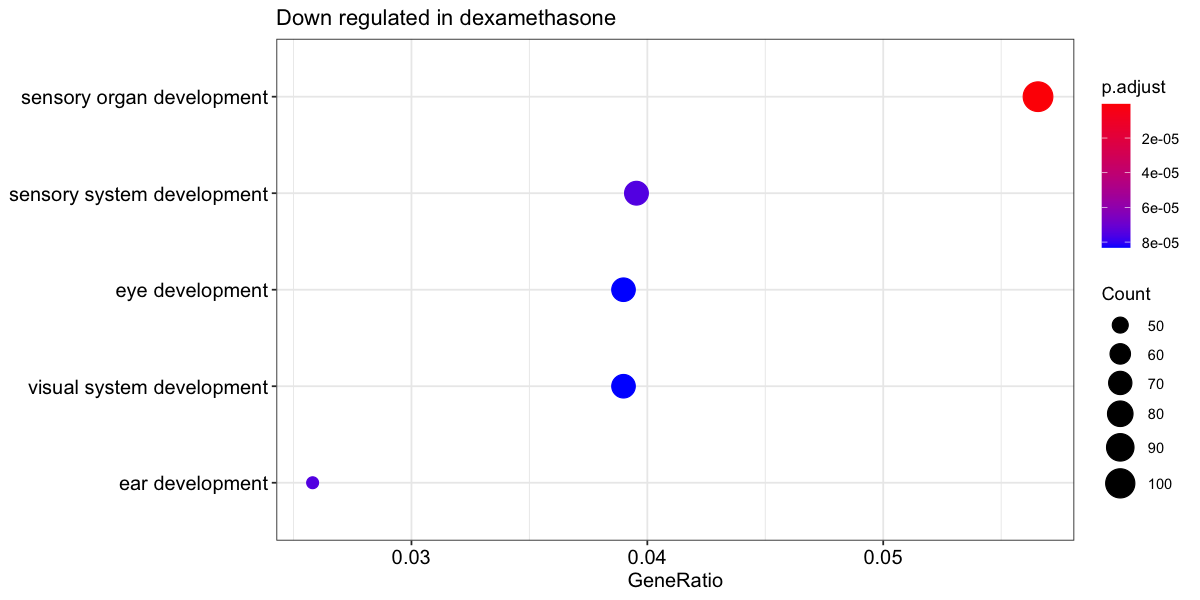

In [35]:
options(repr.plot.height=5, repr.plot.width=10)
emapplot(gsea_out)
up_genes <- data.frame(res) %>% dplyr::filter(padj < 0.1 & log2FoldChange > 0)
down_genes <- data.frame(res) %>% dplyr::filter(padj < 0.1 & log2FoldChange < 0)
up_ego <- enrichGO(gene = rownames(up_genes),
          keyType = 'ENSEMBL',
          ont = 'BP',
          universe = rownames(res),
          OrgDb = orgdb,
          readable = TRUE)
dotplot(up_ego, showCategory = 5) + ggtitle('Up regulated in dexamethasone')

down_ego <- enrichGO(gene = rownames(down_genes),
          keyType = 'ENSEMBL',
          ont = 'BP',
          universe = rownames(res),
          OrgDb = orgdb,
          readable = TRUE)
dotplot(down_ego, showCategory = 5) + ggtitle('Down regulated in dexamethasone')

Note that in each of the calls to `enrichGO` above, I have specified the `universe` argument so that we are taking into consideration which genes were actually detected in our experiment. We also used the `ont = 'BP'` argument to tell `enrichGO` that we want to look at genes in the Biological Process category. We can also set the `showCategory = 5` argument in the call to `dotplot` to tell it to only show us the first 5 categories. The enrichment of `response to peptide hormone` in the up regulated genes makes sense, as dexamethasone is a corticosteroid hormone. 

In this example, we are running `enrichGO` on the up and down regulated genes separately, but it is also valid to run all of the differentially expressed genes together, depending on your research question. https://royalsocietypublishing.org/doi/10.1098/rsif.2013.0950

<div class="alert alert-block alert-success"><b>Exercise:</b> Try running `enrichGO` without setting the `universe` argument. How does this change your results? </div>

<div class="alert alert-block alert-success"><b>Exercise:</b> Try running `enrichGO` on all of the differentially expressed genes without pre-splitting into up and down regulated genes. How does this change your results? </div>